## Theme Extraction Pipeline (High Level)

- Prepare text → Clean and lemmatize customer reviews for linguistic consistency

- Embed reviews → Convert text into semantic vectors

- Discover structure → Cluster embeddings to identify distinct customer contexts

- Focus context → Select the dominant semantic cluster representing core experience

- Extract themes → Use TF-IDF + NMF and noun phrases to uncover latent themes

- Label themes → Generate business-ready summaries, likes, dislikes, and impact

#### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from pyspark.sql import SparkSession
from pyspark.sql.functions import size
import os, sys

In [2]:
PROJECT_ROOT = Path.cwd().parents[0]
sys.path.append(str(PROJECT_ROOT))

from my_reviews_loader import BusinessReviewLoader
from my_preprocessor import MyPreProcessor
from feature_engineering import MyFeatureEngineering
from my_sentence_transformer import MySentenceTransformer
from business_context_clusterer import BusinessContextClusterer
from theme_discovery_engine import ThemeDiscoveryEngine
from theme_labeler import ThemeLabeler

In [3]:
# Initialize Spark Session with Increased Driver Memory
spark = SparkSession.builder \
    .appName('ReviewsProcessing') \
    .config('spark.driver.memory', '8g') \
    .getOrCreate()

25/12/18 11:18:49 WARN Utils: Your hostname, Safaris-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 10.1.10.146 instead (on interface en0)
25/12/18 11:18:49 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/12/18 11:18:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


25/12/18 11:18:49 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


#### LOAD REVIEWS

In [4]:
# LOAD REVIEWS
loader = BusinessReviewLoader(
    business_path="../yelp_dataset/yelp_academic_dataset_business.json",
    reviews_path="../yelp_reviews.parquet"
)

biz_reviews = loader.get_reviews_by_business_name("acme oyster house") # zootampa at lowry park # grand sierra resort and casino

25/12/18 11:18:51 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.



 Selected Business:
business_id: _ab50qdWOk0DdB6XOrBitw
name: Acme Oyster House
city: New Orleans
state: LA
review_count: 7568
is_open: 1


#### PREPROCESS

In [5]:
# PREPROCESS
preprocessor = MyPreProcessor(min_words=3)
clean_reviews = preprocessor.prepare(biz_reviews)

#### ADD LEMMAS

In [6]:
feature_engineer = MyFeatureEngineering()
clean_reviews = feature_engineer.add_features(clean_reviews)

In [7]:
clean_reviews.business_id.value_counts()

business_id
_ab50qdWOk0DdB6XOrBitw    7662
Name: count, dtype: int64

#### EMBED REVIEWS

In [8]:
embedder = MySentenceTransformer()

In [9]:
X = embedder.encode(clean_reviews["text_cleaned"].tolist())

Batches:   0%|          | 0/120 [00:00<?, ?it/s]

#### DISCOVER SEMANTIC STRUCTURE
Discover semantic structure, then extract themes only from the dominant semantic context(considered the most stable context).

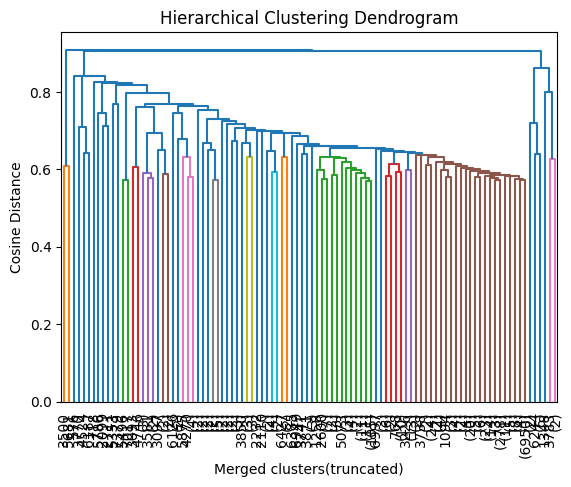

In [10]:
clusterer = BusinessContextClusterer()

Z = clusterer.get_dendrogram(X)
clusterer.plot_dendrogram(Z)
plt.show()

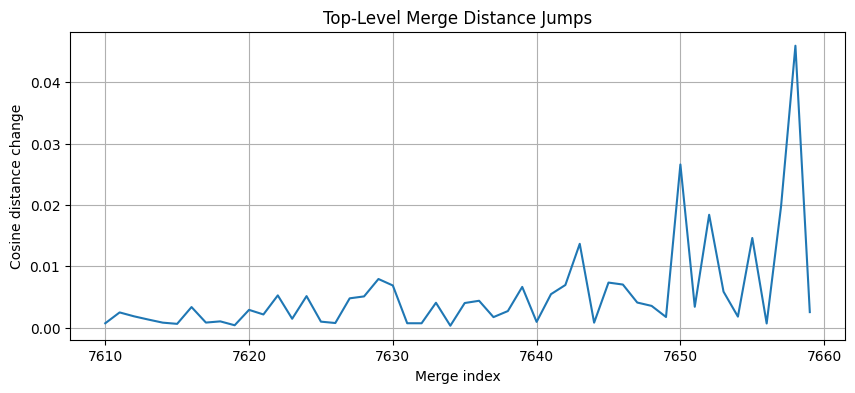

In [11]:
# plot top-level merge jumps only
clusterer.plot_merge_distance_jumps(Z, 50)

In [12]:
cut_height = clusterer.detect_cut_height(Z)

In [13]:
cut_height

0.8403727831165921

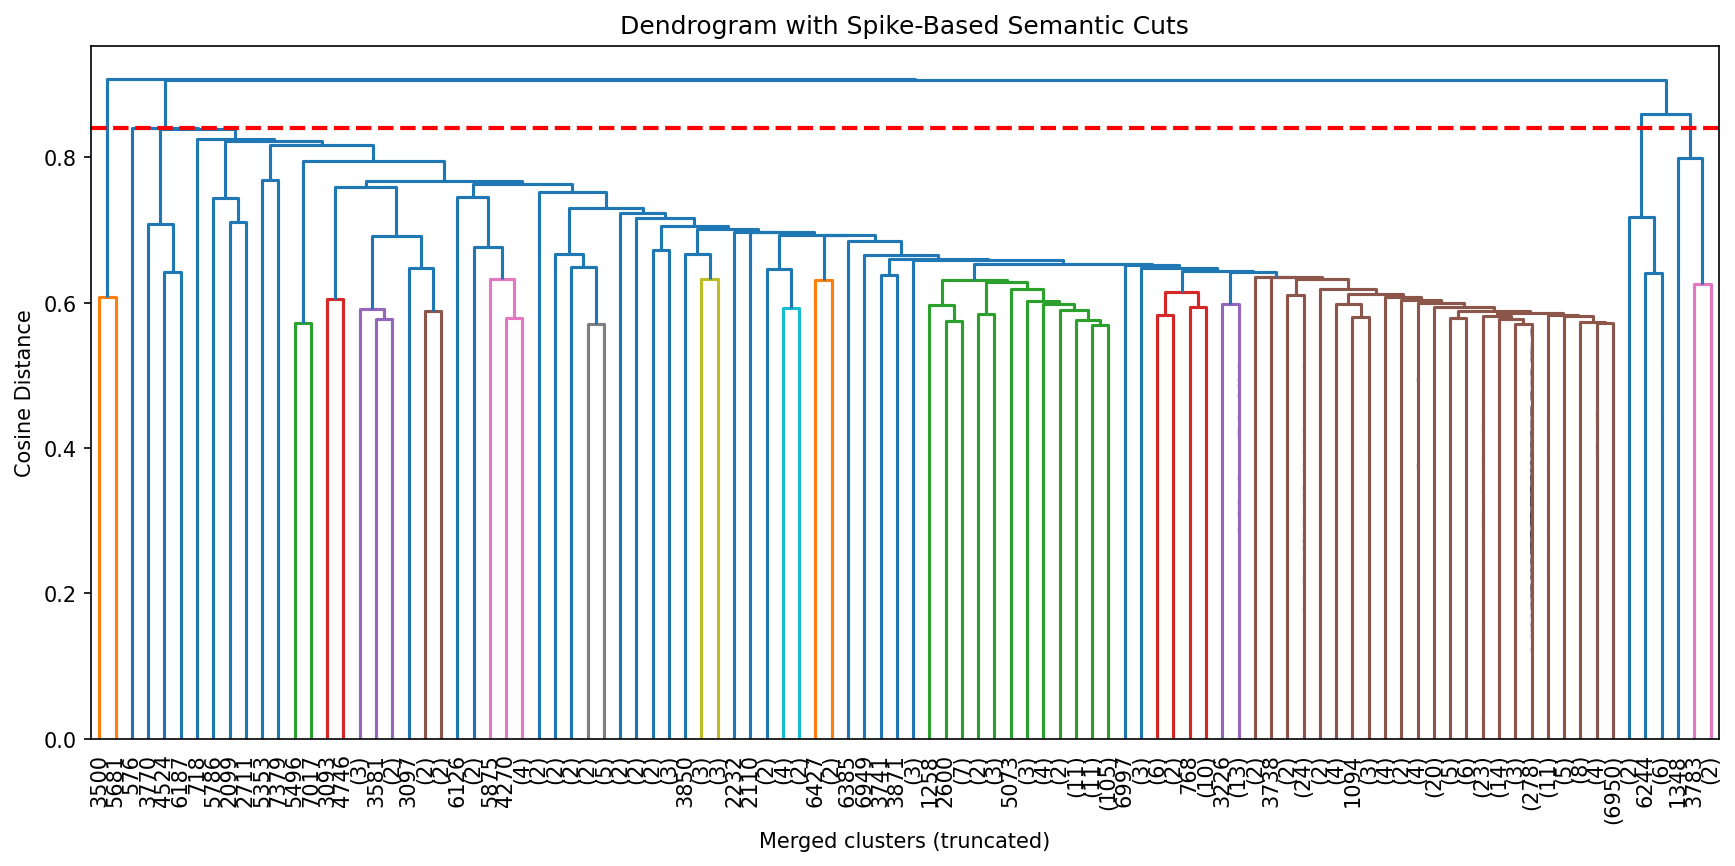

In [14]:
clusterer.plot_dendrogram_with_spikes(Z, cut_height)

In [15]:
# Pick a cut
best_cut = cut_height

In [16]:
labels = clusterer.cut_clusters(X, cut_height=best_cut)

In [17]:
cluster_sizes = pd.Series(labels).value_counts()
cluster_sizes

0    7646
1       9
2       4
3       2
4       1
Name: count, dtype: int64

In [18]:
primary_context_id = cluster_sizes.idxmax()
primary_context_id

0

In [19]:
other_contexts = clean_reviews[labels != primary_context_id]

In [20]:
# foreign languages observed in the other contexts for this business
other_contexts.text

496     C'était assez sympa. Malgré l'ambiance excelle...
576     If I have to ask you ever time I need a drink ...
1348    M8. Nmnnx, ": :%%::'(. No. No.NBneed c. A. E. ...
1717    開店前なら大丈夫だろうと思って5分前に着いたらすでに行列。\n　Chargrilled oy...
3249    Excelente el lugar, la atención y la comida. S...
3500     Killer on the half shell. I toss down 4-5 dozen.
3762    Acme Oyster House es un clásico restaurant de ...
3783    カキをたくさん食べました。安くて美味しいです。カキは生ガキで、一個約1ドル。調理したカキは、...
5636    這家不愧是生蠔專賣店，食物超新鮮！非常值得來吃，只是排隊排了一小時⋯好累啊！店裡客人超多所以...
5681    Repeat.  "I want three dozen of the finest."  ...
6244    Tutto fantastico: po boys con la salsiccia, os...
6549    À voir la fil à l'extérieur et la note de 4 ét...
6833    Excelente lugar los ostiones súper ricos los r...
7103    Los ostiones asados con queso mmm deliciosos.....
7186    Aunque tuvimos que esperar para que nos dieran...
7433    Volvimos a ir a este lugar por que nos encanta...
Name: text, dtype: object

#### Focus context
Select the dominant semantic cluster representing core experience

In [21]:
main_reviews = clean_reviews[labels == primary_context_id].reset_index(drop=True)
X_main = X[labels == primary_context_id]

In [22]:
main_reviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,text_cleaned,lemmas,word_count,char_count,avg_word_length,sentence_count
0,vHLTOsdILT7xgTu7TAWTUQ,417HF4q8ynnWtuJrkNax_g,_ab50qdWOk0DdB6XOrBitw,5.0,0,0,0,This place has amazing oysters and the BEST bl...,2016-07-25 04:34:34,this place has amazing oysters and the best bl...,place amazing oyster best bloody mary stay nol...,107,557,4.214953,7
1,I90lP6oPICTkrhCFGQt5tA,1UAb3zZQeGX6fzZax5DY1A,_ab50qdWOk0DdB6XOrBitw,5.0,0,0,0,OH MY!! A must try. We had no idea there would...,2016-12-19 20:27:16,oh my!! a must try. we had no idea there would...,oh must try idea would line definitely well wo...,82,425,4.195122,12
2,469eAl2fB069YTF_B5zW7w,p2kXD3gNu3N776C0WrmBjA,_ab50qdWOk0DdB6XOrBitw,5.0,0,0,0,The fried seafood was extremely hot. Very nice...,2018-08-23 20:58:39,the fried seafood was extremely hot. very nice...,fried seafood extremely hot nice taste add sof...,97,530,4.474227,16
3,aPpHBDs7Jiiq0sb9YutOhQ,7cDhfvTSH1wTxEmXMj_ChQ,_ab50qdWOk0DdB6XOrBitw,5.0,0,0,0,I love this place. I wish my stay was longer s...,2013-06-24 18:07:12,i love this place. i wish my stay was longer s...,love place wish stay longer could visit food a...,40,193,3.850000,5
4,k9OG5kA5ebruSx_f1T-P-A,7QTh-fkw9Nr2lO10-PV8yw,_ab50qdWOk0DdB6XOrBitw,3.0,0,0,0,"Loved the chargrilled oysters! I mean, seriou...",2010-10-06 08:03:20,"loved the chargrilled oysters! i mean, serious...",love chargrilled oyster mean seriously never t...,230,1277,4.556522,17


#### THEME DISCOVERY
TF-IDF finds signal words; NMF groups those signal words into themes.
Number of topics is currently set to 3

In [23]:
engine = ThemeDiscoveryEngine(
    n_topics=3,       
    n_top_words=10
)

In [24]:
# Load .env
from dotenv import load_dotenv
load_dotenv()

True

In [25]:
from openai import OpenAI
client = OpenAI()

In [26]:
theme_output = engine.discover(main_reviews.lemmas.tolist(), main_reviews.text_cleaned.tolist())
theme_output

{'themes': [{'theme_id': 0,
   'terms': ['oyster',
    'good',
    'order',
    'chargrilled',
    'raw',
    'fried',
    'shrimp',
    'dozen',
    'gumbo',
    'like'],
   'noun_phrases': ['chargrilled oysters',
    'a dozen chargrilled oysters',
    'the fried oysters',
    'my dislike',
    'a fried peace maker po-boy',
    'the half',
    'a half dozen',
    'the seasoned butter',
    'these taste',
    'the bread'],
   'examples': ['amazing. i do not even like oysters and i thought the oysters were unbelievable! that is pretty impressive. the chargrilled oysters were mouthwatering. we started out with a half dozen of them and ordered another half dozen later on. we also had a dozen oysters on the half she will. the chargrilled oysters were the best oysters i have ever eaten. the seasoned butter and cheese would make anything taste great and boy did they make these taste awesome. the oyster on the half she will would be second best (a far second due to my dislike of raw oysters).

In [27]:
labeler = ThemeLabeler(client=client)

labeled_themes = {}

for theme in theme_output["themes"]:
    labeled = labeler.label_theme(
        cluster_id=theme["theme_id"],
        terms=theme["terms"],
        noun_phrases=theme["noun_phrases"],
        examples=theme["examples"],
    )
    labeled_themes[theme["theme_id"]] = labeled

In [28]:
labeled_themes

{0: {'theme_name': 'Chargrilled Oysters Experience',
  'summary': "Customers consistently rave about the chargrilled oysters, highlighting their flavor and the delicious seasoned butter. Many recommend ordering them, often stating they are the best oysters they've ever had. However, there are mixed feelings regarding raw oysters, with some expressing a dislike for their taste.",
  'likes': ['chargrilled oysters', 'seasoned butter', 'flavorful oysters'],
  'dislikes': ['raw oysters'],
  'business_impact': "The popularity of chargrilled oysters can drive repeat visits and attract new customers, while mixed reviews on raw oysters may influence some customers' choices."},
 1: {'theme_name': 'Food Quality and Wait Time',
  'summary': 'Customers appreciate the quality of food, particularly the chargrilled oysters, and feel that the wait time is justified. Many reviews highlight that the food and service are worth the wait, although some mention the need to arrive early to avoid longer lines.

#### Observation: 
- Theme 0 -> Food Experience/ Product
- Theme 1 -> Food/Wait time trade off
- Theme 2 -> Business reputation in New Orleans

## Conclusions and Next Steps

### Key Conclusions
- The current pipeline successfully discovers **dominant semantic contexts** within business reviews and extracts **coherent, business-relevant themes** from the primary context.
- Combining **semantic clustering (embeddings + hierarchical clustering)** with **lexical modeling (TF-IDF + NMF)** produces interpretable themes that align well with real customer experiences.
- LLM-based theme labeling adds a clear business narrative layer on top of deterministic signals, making results stakeholder-ready.
- Some overlap between themes is expected, especially in businesses where core offerings are tightly related (e.g., oysters, wait times, and service in a restaurant).

---

### Immediate Next Steps (Within Current Scope)
- **Trend Analysis**  
  Track how discovered themes evolve over time (e.g., rising complaints, improving sentiment).

- **Theme Label Consistency & Assignment**  
  Persist theme labels and reuse them across time windows or new reviews to enable comparison and prediction.

- **Non-Dominant Semantic Context Handling**  
  Decide whether smaller clusters represent:
  - niche but important issues (e.g., EV charging, bathrooms), or
  - true noise that should be deprioritized.

- **Parameter Tuning & Sensitivity Analysis**  
  Systematically evaluate:
  - number of semantic clusters  
  - TF-IDF thresholds (`min_df`, `max_df`, `max_features`)  
  - number of NMF topics  
  to improve theme separation and stability.

---

### Future Extension (Secondary Goal)

#### Aspect-Based Theme Extraction (ABTA)
This is a **follow-on objective**, not part of the current system.

- Move from review-level analysis to **sentence-level aspect extraction**.
- Allow a single review to contribute to multiple aspects (e.g., food quality vs. wait time).
- Enable highly precise attribution of likes and dislikes to specific aspects.

**Value of ABTA**
- Reduces theme overlap.
- Improves interpretability and actionability.
- Unlocks fine-grained insights for operations and forecasting.

---

**Summary**
The current system establishes a strong, scalable foundation for semantic theme discovery. Aspect-based analysis represents a natural and valuable next phase once the core pipeline is stable and validated.
